In [1]:
import pandas as pd
# contando a quantidade por pacientes
import duckdb
import time
import neurokit2 as nk

# Iniciar contagem do tempo
tempo_inicio = time.time()


import pywt

import logging
from tqdm import tqdm
import duckdb

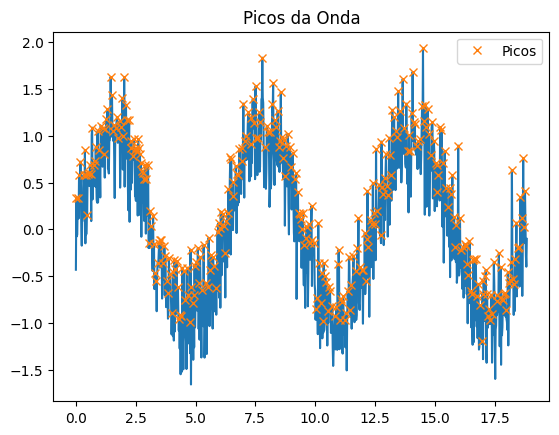

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Exemplo de onda senoidal com ruído
x = np.linspace(0, 6*np.pi, 1000)
y = np.sin(x) + 0.3*np.random.randn(len(x))

# Encontrar os picos
picos, _ = find_peaks(y)

# Visualizar
plt.plot(x, y)
plt.plot(x[picos], y[picos], "x", label="Picos")
plt.legend()
plt.title("Picos da Onda")
plt.show()


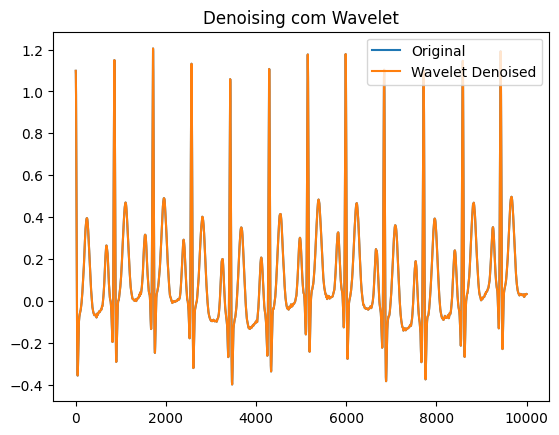

In [8]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Suponha que você tenha um sinal
sinal = nk.ecg_simulate(duration=10, sampling_rate=1000)

# Aplicar transformada wavelet
coeffs = pywt.wavedec(sinal, 'db4', level=5)

# Reconstruir o sinal "limpo" sem ruído de alta frequência
reconstruido = pywt.waverec(coeffs[:-1] + [None], 'db4')

# Plotar
plt.plot(sinal, label='Original')
plt.plot(reconstruido, label='Wavelet Denoised')
plt.legend()
plt.title("Denoising com Wavelet")
plt.show()


## Validação dos atributos

In [2]:
import pywt
import numpy as np
import neurokit2 as nk
import duckdb

conn_leitura = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")

# lista = conn_leitura.execute("""
#     SELECT DISTINCT id_paciente 
#     FROM ecg_pacientes
#     WHERE  (id_paciente > 'P0080' AND id_paciente < 'P0090')
#     ORDER BY id_paciente;
# """).fetchdf()



df = conn_leitura.execute(f"""
SELECT sinal_x FROM ecg_pacientes  
WHERE id_paciente = 'P0010';
""").fetchdf()

# 1. Aplicar decomposição wavelet (wavedec)
coeffs = pywt.wavedec(df['sinal_x'], 'db6', level=4)
coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
ecg_wavelet_filtered = pywt.waverec(coeffs, 'db6')

ecg_limpo = nk.ecg_clean(ecg_wavelet_filtered, sampling_rate=200, method="elgendi2010")
ecg_limpo = ecg_limpo + 2

sampling_rate = 200
epoch_duration_seconds = 60
epoch_length_samples = epoch_duration_seconds * sampling_rate
num_epochs = len(ecg_limpo) // epoch_length_samples
events = [j * epoch_length_samples for j in range(num_epochs)]

epochs = nk.epochs_create(ecg_limpo, events=events, sampling_rate=sampling_rate,
                            epochs_start=0, epochs_end=60)


In [9]:
epochs['1']['Signal'].values

array([2.03584902, 2.15053733, 2.29982434, ..., 2.03487009, 2.03002834,
       2.02165185])

In [20]:
import pywt
import numpy as np
import neurokit2 as nk
import duckdb

conn_leitura = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")

lista = conn_leitura.execute("""
    SELECT DISTINCT id_paciente 
    FROM ecg_pacientes
    WHERE  (id_paciente > 'P0080' AND id_paciente < 'P0090')
    ORDER BY id_paciente;
""").fetchdf()

for i in lista['id_paciente']:
    
    df = conn_leitura.execute(f"""
    SELECT sinal_x FROM ecg_pacientes  
    WHERE id_paciente = '{i}';
    """).fetchdf()
    
    # 1. Aplicar decomposição wavelet (wavedec)
    coeffs = pywt.wavedec(df['sinal_x'], 'db6', level=4)
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
    ecg_wavelet_filtered = pywt.waverec(coeffs, 'db6')

    ecg_limpo = nk.ecg_clean(ecg_wavelet_filtered, sampling_rate=200, method="elgendi2010")
    ecg_limpo = ecg_limpo + 2

    sampling_rate = 200
    epoch_duration_seconds = 60
    epoch_length_samples = epoch_duration_seconds * sampling_rate
    num_epochs = len(ecg_limpo) // epoch_length_samples
    events = [j * epoch_length_samples for j in range(num_epochs)]

    epochs = nk.epochs_create(ecg_limpo, events=events, sampling_rate=sampling_rate,
                              epochs_start=0, epochs_end=60)

    HRV_MeanNN = []
    HRV_rmSSD = []

    for x in range(1, len(epochs) + 1):
        sinal = epochs[f'{x}']['Signal'].values

        # Verifica se o sinal tem tamanho suficiente
        if len(sinal) < 12000:
            print(f"⚠️ Paciente: {i} - Epoch: {x} - Sinal curto: {len(sinal)} amostras")

        # Detecta picos e calcula HRV se possível
        peaks, _ = nk.ecg_peaks(sinal, sampling_rate=200)
        n_picos = np.sum(peaks["ECG_R_Peaks"])

        if n_picos > 2:
            try:
                hrv_time = nk.hrv_time(peaks, sampling_rate=200, show=False)
                HRV_MeanNN.append(hrv_time['HRV_MeanNN'].values[0])
                HRV_rmSSD.append(hrv_time['HRV_RMSSD'].values[0])
            except Exception as e:
                print(f"❌ Erro ao calcular HRV para paciente {i}, epoch {x}: {e}")
                HRV_MeanNN.append(np.nan)
                HRV_rmSSD.append(np.nan)
        else:
            print(f"⚠️ Poucos picos detectados - Paciente: {i} - Epoch: {x} - Picos: {n_picos}")
            HRV_MeanNN.append(np.nan)
            HRV_rmSSD.append(np.nan)


In [9]:
import pywt
import numpy as np
import logging
from tqdm import tqdm
import duckdb


conn_leitura = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")

# lista = conn_leitura.execute(f"""
#     SELECT DISTINCT id_paciente 
#     FROM ecg_pacientes 
#     ORDER BY id_paciente;
# """).fetchdf()

df = conn_leitura.execute(f"""
SELECT  sinal_z FROM ecg_pacientes  
WHERE id_paciente = 'P0015';
""").fetchdf()


df['sinal_z'].head()

0   -1.51
1   -1.47
2   -1.45
3   -1.41
4   -1.39
Name: sinal_z, dtype: float32

In [4]:
import numpy as np
import pandas as pd
import neurokit2 as nk


class ECGProcessor:
    def __init__(self):
        pass

    def epocas(self):
        """
        Divide o sinal de ECG limpo em épocas de 60 segundos.
        """
        sampling_rate = 200  # Taxa de amostragem em Hz
        epoch_duration_seconds = 60  # Duração de cada época em segundos
        epoch_length_samples = epoch_duration_seconds * sampling_rate  # Tamanho da época em amostras

        # Número total de épocas que cabem no sinal
        num_epochs = len(self.ecg_limpo) // epoch_length_samples

        # Eventos (índices de início de cada época)
        events = [i * epoch_length_samples for i in range(num_epochs)]

        # Criação das épocas usando o NeuroKit
        epochs = nk.epochs_create(self.ecg_limpo,
                                  events=events,
                                  sampling_rate=sampling_rate,
                                  epochs_start=0,
                                  epochs_end=60)
        return epochs



    def qts(self):
        """
        Calcula duas medidas para cada época:
        - Duração média do complexo QRS (QRS Duration)
        - Intervalo QT corrigido (QTc), usando a fórmula de Bazett
        """
        epochs = self.epocas()

        qrs_duration_media = []
        qt_interval_media = []
        HRV_MeanNN = []
        HRV_rmSSD = []
        epoca = []

        for x in range(1, 61):
            sinal = epochs[f'{x}']['Signal'].values

            # Detecção dos picos R no sinal
            peaks, info = nk.ecg_peaks(sinal, sampling_rate=200)
            
            
            
            
            # Verifica se há batimentos detectados
            if len(info["ECG_R_Peaks"]) == 0:
                print(f"Nenhum R-peak detectado para o paciente {self.id_paciente}. Pulando cálculo do QRS/QT.")
                continue  # Pula para a próxima época
                # return np.nan, np.nan  # Ou zeros, ou outro tratamento que preferir
            
            
            #==========================================calculo HRV==================================
            """
            Calcula duas métricas de variabilidade da frequência cardíaca (HRV) para cada época:
            - HRV_MeanNN: média dos intervalos NN
            - HRV_RMSSD: raiz quadrada da média dos quadrados das diferenças sucessivas entre intervalos NN
            """
                
            
            hrv_time = nk.hrv_time(peaks, sampling_rate=200, show=False)  # Calcula HRV

            HRV_MeanNN.append(hrv_time['HRV_MeanNN'].values[0])   
            HRV_rmSSD.append(hrv_time['HRV_RMSSD'].values[0]) 
            epoca.append(x)  # Número da época
            

            
            
            #==========================================calculo dos QTs==================================
            

            # Delineamento das ondas (P, QRS, T) com a transformada wavelet
            delineate, _ = nk.ecg_delineate(sinal, rpeaks=info["ECG_R_Peaks"],
                                            sampling_rate=200, method="dwt")

            # Índices dos picos relevantes
            q_peaks = delineate[delineate["ECG_Q_Peaks"] == 1].index.to_numpy()
            s_peaks = delineate[delineate["ECG_S_Peaks"] == 1].index.to_numpy()
            t_offsets = delineate[delineate["ECG_T_Offsets"] == 1].index.to_numpy()

            # Verifica se há pares suficientes para análise
            if len(q_peaks) == 0 or len(s_peaks) == 0 or len(t_offsets) == 0:
                qrs_duration_media.append(np.nan)
                qt_interval_media.append(np.nan)
                continue

            # Garante que os pares tenham o mesmo tamanho
            min_len_qs = min(len(q_peaks), len(s_peaks))
            min_len_qt = min(len(q_peaks), len(t_offsets))

            q_peaks_qs = q_peaks[:min_len_qs]
            s_peaks_qs = s_peaks[:min_len_qs]
            q_peaks_qt = q_peaks[:min_len_qt]
            t_offsets_qt = t_offsets[:min_len_qt]

            # Seleciona apenas pares válidos (respeitando a ordem no tempo)
            pares_qs = [(q, s) for q, s in zip(q_peaks_qs, s_peaks_qs) if s > q]
            pares_qt = [(q, t) for q, t in zip(q_peaks_qt, t_offsets_qt) if t > q]

            fs = 200  # Frequência de amostragem
            # Cálculo da duração do complexo QRS em milissegundos
            qrs_duration_ms = [(s - q) / fs * 1000 for q, s in pares_qs]
            # Cálculo do intervalo QT em milissegundos
            qt_interval_ms = [(t - q) / fs * 1000 for q, t in pares_qt]

            # Aplica média apenas se houver pares válidos
            qrs_duration_media.append(np.nanmean(qrs_duration_ms) if len(qrs_duration_ms) > 0 else np.nan)
            qt_interval_media.append(np.nanmean(qt_interval_ms) if len(qt_interval_ms) > 0 else np.nan)

            # Cálculo do intervalo RR médio em segundos
            rr_intervals = np.diff(info["ECG_R_Peaks"]) / fs
            rr_medio = np.mean(rr_intervals)

            # Cálculo do QTc (intervalo QT corrigido) usando a fórmula de Bazett
            if len(qt_interval_ms) > 0 and rr_medio > 0:
                qt_c_medio = np.nanmean(qt_interval_ms) / np.sqrt(rr_medio)
            else:
                qt_c_medio = np.nan

            # Substitui o valor do intervalo QT pela versão corrigida (QTc)
            qt_interval_media[-1] = qt_c_medio

        return qrs_duration_media, qt_interval_media, HRV_MeanNN, HRV_rmSSD, epoca
    
    def wavelet_filter_preservando_qrs(self, signal, wavelet='db6', level=4, atenuacao=0.2):
        coeffs = pywt.wavedec(signal, wavelet, level=level) # menos agressivo

        # Mantém detalhes de nível 1 e 2 (alta frequência = QRS)
        for i in range(3, len(coeffs)):  # Atenua detalhes de nível mais alto
            coeffs[i] *= atenuacao # mantém 20% da energia

        ecg_wavelet_filtered = pywt.waverec(coeffs, wavelet)
        return ecg_wavelet_filtered

    def process(self, signal, sampling_rate=200,metodo='neurokit', id_paciente=None):
        """
        Função principal de processamento.
        Limpa o sinal, calcula as métricas HRV, QRS e QTc, e retorna um DataFrame com os resultados.
        """
        #self.signal = signal
        self.fs = sampling_rate
        self.id_paciente = id_paciente  # salva o ID internamente
        
        # teste1
        ##1. Aplicar decomposição wavelet (wavedec)
        # coeffs = pywt.wavedec(signal, 'db6', level=4)
        # # Zero out os coeficientes de detalhe de alto nível (por exemplo, ruído)
        # coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
        # ecg_wavelet_filtered = pywt.waverec(coeffs, 'db6')
        
        #teste2
        # Por exemplo: preserve cD1 e cD2
        # zera só os detalhes de níveis mais altos
        ecg_wavelet_filtered = self.wavelet_filter_preservando_qrs(signal, wavelet='db6', level=2, atenuacao=0.2)


        # Limpeza do sinal com o método de Pan-Tompkins
        ecg_limpo = nk.ecg_clean(ecg_wavelet_filtered, sampling_rate=200, method=metodo)

        # Ajuste de escala (opcional): desloca o sinal para cima, garantindo valores positivos
        self.ecg_limpo = ecg_limpo + 2

        # Cálculo das métricas de HRV
        #HRV_MeanNN, HRV_rmSSD, epoca = self.hrv()

        # Cálculo das métricas QRS de QTc e HRV
        qrs_duration_media, qt_interval_media, HRV_MeanNN, HRV_rmSSD, epoca = self.qts()

        # Construção do DataFrame com os resultados
        df = pd.DataFrame({
            'Epoca': epoca,
            'HRV_MeanNN': HRV_MeanNN,
            'HRV_rmSSD': HRV_rmSSD,
            'QRS_Duration': qrs_duration_media,
            'QT_Interval': qt_interval_media
        })

        return df



def destacar_valores(df):
    # Valores ideais como referência
    ideais = {
        'HRV_MeanNN': 800,
        'HRV_rmSSD': 50,
        'QRS_Duration': 100,
        'QT_Interval': 400
    }

    def cor_celula(valor, ideal):
        if pd.isna(valor):
            return 'background-color: #A9A9A9'  # Cinza para NaN
        desvio = abs(valor - ideal) / ideal
        if desvio <= 0.2:
            return 'background-color: #007e80'  # Verde
        elif desvio <= 0.4:
            return 'background-color: orange'  # Amarelo queimado
        else:
            return 'background-color: lightcoral'  # Vermelho

    def aplicar_estilo(coluna):
        ideal = ideais.get(coluna.name, None)
        if ideal is None:
            return ['' for _ in coluna]
        return [cor_celula(v, ideal) for v in coluna]

    return df.style.apply(aplicar_estilo, subset=list(ideais.keys()), axis=0)

In [10]:
atributos = ECGProcessor()
variavel = atributos.process(df['sinal_z'], sampling_rate=200,metodo='elgendi2010')
df_estilizado = destacar_valores(variavel)
df_estilizado

# usando wavedec e elgendi2010 mais ou menos HRV_MeanNN mais amarelo e pouco verde nenhum vermelho HRV_rmSSD todos vermelho
# QRS_Duration	autro amarelo de 60 e o resto todos vermelho  QT_Interval metade amarelo e verde

 # saundo elgendi2010 sem o wavedec HRV_MeanNN  metade vermelho e amarelo HRV_rmSSD	 dois amarelo e o resto vermelho QRS_Duration
 #  todos verde QT_Interval todos amarelo 

,Epoca,HRV_MeanNN,HRV_rmSSD,QRS_Duration,QT_Interval
0,1,520.350877,4.046193,82.894737,271.297988
1,2,525.133929,4.601214,83.035714,270.508166
2,3,519.078947,4.336509,82.763158,270.838781
3,4,518.000000,4.392977,82.565217,269.790096
4,5,517.850877,4.127396,82.938596,271.403529
5,6,521.283186,4.677072,83.407080,270.696164
6,7,521.491228,4.412372,83.333333,270.454582
7,8,515.478261,4.240573,82.391304,269.601400
8,9,481.585366,5.317771,80.731707,276.542734
9,10,477.258065,3.956059,80.604839,275.611709


In [ ]:
# saiu melhor pantompkins1985
# saiu melhor hamilton2002 para QRS_Duration
# saiu melhor elgendi2010 do que hamilton2002 e pantompkins1985
# saiu melhor elgendi2010 trouxe todos os valores 
# saiu melhor elgendi2010 no QT_Interval
# alguns pontos engzeemod2012 pouco com valores nulos
# saiu melhor vg para QRS_Duration e HRV_MeanNN	

In [ ]:
%%time

import logging
from tqdm import tqdm
import duckdb

# Conexões separadas
conn_leitura = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")



# # Lista de pacientes únicos
# lista = conn_leitura.execute("""
#     SELECT DISTINCT id_paciente FROM ecg_pacientes ORDER BY id_paciente;
# """).fetchdf()

# Seleciona 5 pacientes a partir da posição 10 (ou seja, índices 10 a 14)
lista = conn_leitura.execute("""
    SELECT DISTINCT id_paciente 
    FROM ecg_pacientes 
    ORDER BY id_paciente 
    LIMIT 5 OFFSET 10;
""").fetchdf()


# Logging configurado
logging.basicConfig(filename='processamento_ecg.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Processar pacientes
for paciente in tqdm(lista['id_paciente'], desc="Processando pacientes", unit="paciente"):

    # Consulta dados do paciente
    df = conn_leitura.execute(f"""
        SELECT * FROM ecg_pacientes
        WHERE id_paciente = '{paciente}';
    """).fetchdf()

    # Sinal
    ecg_x = df['sinal_x'].values

    # Processamento
    atributos = ECGProcessor()
    variavel = atributos.process(ecg_x, sampling_rate=200)
    
    # Adicionar colunas extras
    variavel['id_paciente'] = paciente
    


    # Limpar memória
    del ecg_x








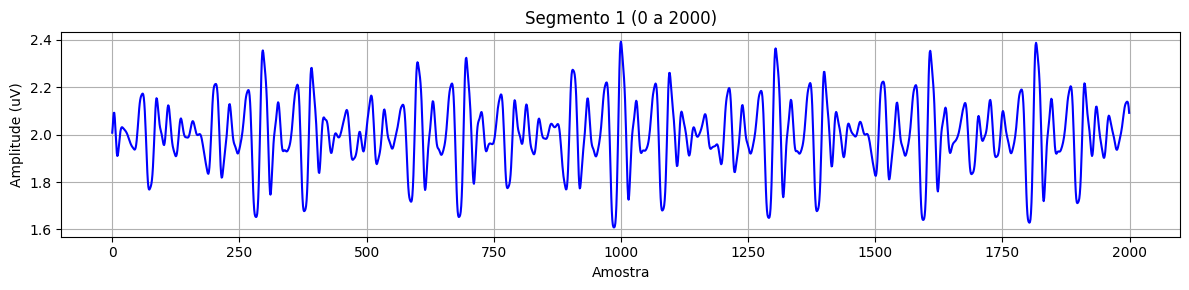

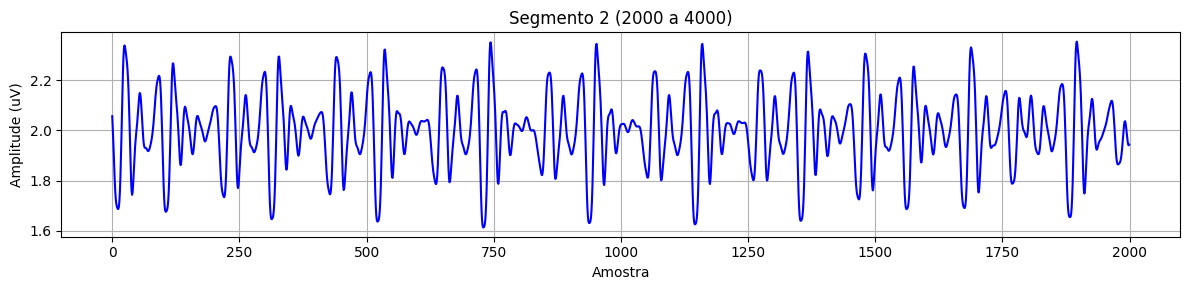

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que ecg_limpo já está definido
# Exemplo: ecg_limpo = nk.ecg_clean(seu_sinal, sampling_rate=200)


df = conn_leitura.execute(f"""
SELECT  sinal_x FROM ecg_pacientes  
WHERE id_paciente = 'P0015';
""").fetchdf()


# 1. Aplicar decomposição wavelet (wavedec)
coeffs = pywt.wavedec(df['sinal_x'], 'db6', level=4)
# Zero out os coeficientes de detalhe de alto nível (por exemplo, ruído)
coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
ecg_wavelet_filtered = pywt.waverec(coeffs, 'db6')

ecg_limpo = nk.ecg_clean(ecg_wavelet_filtered, sampling_rate=200, method="elgendi2010")

ecg_limpo = ecg_limpo + 2

segmento = 2000
total_amostras = 4000#len(ecg_limpo)  # 720000
num_segmentos = total_amostras // segmento

# Criar os subplots
for i in range(num_segmentos):
    inicio = i * segmento
    fim = inicio + segmento
    plt.figure(figsize=(12, 3))
    plt.plot(ecg_limpo[inicio:fim], color='blue')
    plt.title(f'Segmento {i+1} ({inicio} a {fim})')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude (uV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Extraindo dados e Salvando os atributos do ECG 

In [ ]:
#!pip install tqdm


In [11]:
class ECGProcessor:
    def __init__(self):
        pass

    def epocas(self):
        """
        Divide o sinal de ECG limpo em épocas de 60 segundos.
        """
        sampling_rate = 200  # Taxa de amostragem em Hz
        epoch_duration_seconds = 60  # Duração de cada época em segundos
        epoch_length_samples = epoch_duration_seconds * sampling_rate  # Tamanho da época em amostras

        # Número total de épocas que cabem no sinal
        num_epochs = len(self.ecg_limpo) // epoch_length_samples

        # Eventos (índices de início de cada época)
        events = [i * epoch_length_samples for i in range(num_epochs)]

        # Criação das épocas usando o NeuroKit
        epochs = nk.epochs_create(self.ecg_limpo,
                                  events=events,
                                  sampling_rate=sampling_rate,
                                  epochs_start=0,
                                  epochs_end=60)
        return epochs



    def qts(self):
        """
        Calcula duas medidas para cada época:
        - Duração média do complexo QRS (QRS Duration)
        - Intervalo QT corrigido (QTc), usando a fórmula de Bazett
        """
        epochs = self.epocas()

        qrs_duration_media = []
        qt_interval_media = []
        HRV_MeanNN = []
        HRV_rmSSD = []
        epoca = []

        for x in range(1, 61):
            sinal = epochs[f'{x}']['Signal'].values

            # Detecção dos picos R no sinal
            peaks, info = nk.ecg_peaks(sinal, sampling_rate=200)
            
            
            
            
            # Verifica se há batimentos detectados
            if len(info["ECG_R_Peaks"]) == 0:
                print(f"Nenhum R-peak detectado para o paciente {self.id_paciente}. Pulando cálculo do QRS/QT.")
                continue  # Pula para a próxima época
                # return np.nan, np.nan  # Ou zeros, ou outro tratamento que preferir
            
            
            #==========================================calculo HRV==================================
            """
            Calcula duas métricas de variabilidade da frequência cardíaca (HRV) para cada época:
            - HRV_MeanNN: média dos intervalos NN
            - HRV_RMSSD: raiz quadrada da média dos quadrados das diferenças sucessivas entre intervalos NN
            """
                
            
            hrv_time = nk.hrv_time(peaks, sampling_rate=200, show=False)  # Calcula HRV

            HRV_MeanNN.append(hrv_time['HRV_MeanNN'].values[0])   
            HRV_rmSSD.append(hrv_time['HRV_RMSSD'].values[0]) 
            epoca.append(x)  # Número da época
            

            
            
            #==========================================calculo dos QTs==================================
            

            # Delineamento das ondas (P, QRS, T) com a transformada wavelet
            delineate, _ = nk.ecg_delineate(sinal, rpeaks=info["ECG_R_Peaks"],
                                            sampling_rate=200, method="dwt")

            # Índices dos picos relevantes
            q_peaks = delineate[delineate["ECG_Q_Peaks"] == 1].index.to_numpy()
            s_peaks = delineate[delineate["ECG_S_Peaks"] == 1].index.to_numpy()
            t_offsets = delineate[delineate["ECG_T_Offsets"] == 1].index.to_numpy()

            # Verifica se há pares suficientes para análise
            if len(q_peaks) == 0 or len(s_peaks) == 0 or len(t_offsets) == 0:
                qrs_duration_media.append(np.nan)
                qt_interval_media.append(np.nan)
                continue

            # Garante que os pares tenham o mesmo tamanho
            min_len_qs = min(len(q_peaks), len(s_peaks))
            min_len_qt = min(len(q_peaks), len(t_offsets))

            q_peaks_qs = q_peaks[:min_len_qs]
            s_peaks_qs = s_peaks[:min_len_qs]
            q_peaks_qt = q_peaks[:min_len_qt]
            t_offsets_qt = t_offsets[:min_len_qt]

            # Seleciona apenas pares válidos (respeitando a ordem no tempo)
            pares_qs = [(q, s) for q, s in zip(q_peaks_qs, s_peaks_qs) if s > q]
            pares_qt = [(q, t) for q, t in zip(q_peaks_qt, t_offsets_qt) if t > q]

            fs = 200  # Frequência de amostragem
            # Cálculo da duração do complexo QRS em milissegundos
            qrs_duration_ms = [(s - q) / fs * 1000 for q, s in pares_qs]
            # Cálculo do intervalo QT em milissegundos
            qt_interval_ms = [(t - q) / fs * 1000 for q, t in pares_qt]

            # Aplica média apenas se houver pares válidos
            qrs_duration_media.append(np.nanmean(qrs_duration_ms) if len(qrs_duration_ms) > 0 else np.nan)
            qt_interval_media.append(np.nanmean(qt_interval_ms) if len(qt_interval_ms) > 0 else np.nan)

            # Cálculo do intervalo RR médio em segundos
            rr_intervals = np.diff(info["ECG_R_Peaks"]) / fs
            rr_medio = np.mean(rr_intervals)

            # Cálculo do QTc (intervalo QT corrigido) usando a fórmula de Bazett
            if len(qt_interval_ms) > 0 and rr_medio > 0:
                qt_c_medio = np.nanmean(qt_interval_ms) / np.sqrt(rr_medio)
            else:
                qt_c_medio = np.nan

            # Substitui o valor do intervalo QT pela versão corrigida (QTc)
            qt_interval_media[-1] = qt_c_medio

        return qrs_duration_media, qt_interval_media, HRV_MeanNN, HRV_rmSSD, epoca
    
    def wavelet_filter_preservando_qrs(self, signal, wavelet='db6', level=4, atenuacao=0.2):
        coeffs = pywt.wavedec(signal, wavelet, level=level) # menos agressivo

        # Mantém detalhes de nível 1 e 2 (alta frequência = QRS)
        for i in range(3, len(coeffs)):  # Atenua detalhes de nível mais alto
            coeffs[i] *= atenuacao # mantém 20% da energia

        ecg_wavelet_filtered = pywt.waverec(coeffs, wavelet)
        return ecg_wavelet_filtered

    def process(self, signal, sampling_rate=200,metodo='neurokit', id_paciente=None):
        """
        Função principal de processamento.
        Limpa o sinal, calcula as métricas HRV, QRS e QTc, e retorna um DataFrame com os resultados.
        """
        #self.signal = signal
        self.fs = sampling_rate
        self.id_paciente = id_paciente  # salva o ID internamente
        
        # teste1
        ##1. Aplicar decomposição wavelet (wavedec)
        # coeffs = pywt.wavedec(signal, 'db6', level=4)
        # # Zero out os coeficientes de detalhe de alto nível (por exemplo, ruído)
        # coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
        # ecg_wavelet_filtered = pywt.waverec(coeffs, 'db6')
        
        #teste2
        # Por exemplo: preserve cD1 e cD2
        # zera só os detalhes de níveis mais altos
        ecg_wavelet_filtered = self.wavelet_filter_preservando_qrs(signal, wavelet='db6', level=2, atenuacao=0.2)


        # Limpeza do sinal com o método de Pan-Tompkins
        ecg_limpo = nk.ecg_clean(ecg_wavelet_filtered, sampling_rate=200, method=metodo)

        # Ajuste de escala (opcional): desloca o sinal para cima, garantindo valores positivos
        self.ecg_limpo = ecg_limpo + 2

        # Cálculo das métricas de HRV
        #HRV_MeanNN, HRV_rmSSD, epoca = self.hrv()

        # Cálculo das métricas QRS de QTc e HRV
        qrs_duration_media, qt_interval_media, HRV_MeanNN, HRV_rmSSD, epoca = self.qts()

        # Construção do DataFrame com os resultados
        df = pd.DataFrame({
            'Epoca': epoca,
            'HRV_MeanNN': HRV_MeanNN,
            'HRV_rmSSD': HRV_rmSSD,
            'QRS_Duration': qrs_duration_media,
            'QT_Interval': qt_interval_media
        })

        return df


In [ ]:
%%time
import os
import logging
from tqdm import tqdm
import duckdb

# Conexões separadas
conn_leitura = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")
conn_escrita = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/atributos_ecg.duckdb")

# Cria a tabela com a coluna extra 'epoca'
conn_escrita.execute("""
    CREATE TABLE IF NOT EXISTS atributos_ecg(
        id_paciente TEXT,
        Epoca INTEGER,
        HRV_MeanNN FLOAT,
        HRV_rmSSD FLOAT,
        QRS_Duration FLOAT,
        QT_Interval FLOAT
    )
""")


#------------------------------------------Seperando em lote para salvar os dados
# Caminho do arquivo que guarda o número do lote atual
caminho_lote = r"D:\Projeto_Tese_mestrado\05_Modelos\Projeto_regressao_cox\lote_atual.txt"

# Se o arquivo já existe, lê o número do lote. Se não, começa do 1.
if os.path.exists(caminho_lote):
    with open(caminho_lote, "r") as arquivo:
        numero_lote = int(arquivo.read().strip())
else:
    numero_lote = 1

# Define tamanho do lote e calcula o offset
tamanho_lote = 200
offset = (numero_lote - 1) * tamanho_lote

# Consulta SQL para pegar o lote atual
lista = conn_leitura.execute(f"""
    SELECT DISTINCT id_paciente 
    FROM ecg_pacientes 
    ORDER BY id_paciente 
    LIMIT {tamanho_lote} OFFSET {offset};
""").fetchdf()

print(f"Processando lote {numero_lote} com OFFSET {offset}")

# === PROCESSAMENTO DOS PACIENTES ===
# por exemplo: processar_pacientes(lista)

# Depois de processar, salva o próximo número do lote
with open(caminho_lote, "w") as arquivo:
    arquivo.write(str(numero_lote + 1))



#---------------------------------------Processo de lotes
# Logging configurado
logging.basicConfig(filename='processamento_ecg.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Processar pacientes
#for paciente in tqdm(lista['id_paciente'], desc="Processando pacientes", unit="paciente"):
for i, paciente in enumerate(tqdm(lista['id_paciente'], desc="Processando pacientes", unit="paciente")):
    tqdm.write(f"➡️  {i+1}/{len(lista)} - Paciente ID: {paciente}")
    
    # Consulta dados do paciente
    df = conn_leitura.execute(f"""
        SELECT * FROM ecg_pacientes
        WHERE id_paciente = '{paciente}';
    """).fetchdf()

    # Sinal
    ecg_x = df['sinal_x'].values

    # Processamento
    atributos = ECGProcessor()
    variavel = atributos.process(ecg_x, sampling_rate=200, metodo="elgendi2010", id_paciente=paciente)
    
    # Adicionar colunas extras
    variavel['id_paciente'] = paciente
    

    # # Registrar o dataframe
    # conn_escrita.register("variavel", variavel)
    # Registrar e inserir no banco com 5 colunas
    conn_escrita.register("variavel", variavel[['id_paciente', 'Epoca', 'HRV_MeanNN', 'HRV_rmSSD', 'QRS_Duration', 'QT_Interval']])


    # # Inserir no banco
    # conn_escrita.execute("""
    #     INSERT INTO atributos_ecg SELECT * FROM variavel
    # """)
    
    # Inserir no banco
    conn_escrita.execute("""
        INSERT INTO atributos_ecg SELECT id_paciente, Epoca, HRV_MeanNN, HRV_rmSSD, QRS_Duration, QT_Interval FROM variavel
    """)
    conn_escrita.unregister("variavel")

    logging.info(f"Processado paciente {paciente}, inseridos {len(variavel)} registros.")

    # Limpar memória
    del ecg_x, df, variavel



In [15]:
%%time

import logging
from tqdm import tqdm
import duckdb

# Conexões separadas
conn_leitura = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")
conn_escrita = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/atributos_ecg.duckdb")

# Cria a tabela com a coluna extra 'epoca'
conn_escrita.execute("""
    CREATE TABLE IF NOT EXISTS atributos_ecg(
        id_paciente TEXT,
        Epoca INTEGER,
        HRV_MeanNN FLOAT,
        HRV_rmSSD FLOAT,
        QRS_Duration FLOAT,
        QT_Interval FLOAT
    )
""")

# # Lista de pacientes únicos
# lista = conn_leitura.execute("""
#     SELECT DISTINCT id_paciente FROM ecg_pacientes ORDER BY id_paciente;
# """).fetchdf()

# Seleciona 5 pacientes a partir da posição 10 (ou seja, índices 10 a 14)
# lista = conn_leitura.execute("""
#     SELECT DISTINCT id_paciente 
#     FROM ecg_pacientes 
#     WHERE id_paciente >= 'P0480' AND id_paciente <= 'P0500'
#     ORDER BY id_paciente  
#     LIMIT 5 OFFSET 10;
# """).fetchdf()
# Lista com apenas o paciente P0488
lista = conn_leitura.execute("""
    SELECT DISTINCT id_paciente 
    FROM ecg_pacientes 
    WHERE id_paciente = 'P0545';
""").fetchdf()


# Logging configurado
logging.basicConfig(filename='processamento_ecg.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Processar pacientes
# for paciente in tqdm(lista['id_paciente'], desc="Processando pacientes", unit="paciente"):
for i, paciente in enumerate(tqdm(lista['id_paciente'], desc="Processando pacientes", unit="paciente")):
    tqdm.write(f"➡️  {i+1}/{len(lista)} - Paciente ID: {paciente}")


    # Consulta dados do paciente
    df = conn_leitura.execute(f"""
        SELECT * FROM ecg_pacientes
        WHERE id_paciente = '{paciente}';
    """).fetchdf()

    # Sinal
    ecg_x = df['sinal_x'].values

    # Processamento
    atributos = ECGProcessor()
    variavel = atributos.process(ecg_x, sampling_rate=200, metodo="elgendi2010",id_paciente=paciente)
    
    # Adicionar colunas extras
    variavel['id_paciente'] = paciente
    


    # Limpar memória
    #del ecg_x








Processando pacientes:   0%|          | 0/1 [00:00<?, ?paciente/s]

➡️  1/1 - Paciente ID: P0545


c:\Users\NOTEBOOK\anaconda3\Lib\site-packages\neurokit2\signal\signal_findpeaks.py:240: PeakPropertyWarning: some peaks have a width of 0
  widths, _, __, ___ = scipy.signal.peak_widths(signal, peaks, rel_height=0.5)


Nenhum R-peak detectado para o paciente P0545. Pulando cálculo do QRS/QT.
Nenhum R-peak detectado para o paciente P0545. Pulando cálculo do QRS/QT.
Nenhum R-peak detectado para o paciente P0545. Pulando cálculo do QRS/QT.


Processando pacientes: 100%|██████████| 1/1 [00:50<00:00, 50.53s/paciente]

CPU times: total: 49.7 s
Wall time: 50.6 s


In [16]:
variavel

,Epoca,HRV_MeanNN,HRV_rmSSD,QRS_Duration,QT_Interval,id_paciente
0,1,850.072464,1103.814409,63.478261,208.590180,P0545
1,2,806.849315,1074.159070,65.136986,225.019490,P0545
2,3,801.013514,1016.644023,62.364865,272.310574,P0545
3,4,724.268293,38.433846,62.439024,261.946502,P0545
4,5,706.071429,1000.465103,64.285714,296.173752,P0545
5,6,740.250000,1026.335037,63.187500,287.591676,P0545
6,7,717.865854,17.993483,65.792683,242.673341,P0545
7,8,695.705882,29.088330,64.294118,253.534541,P0545
8,9,763.051948,1054.174034,65.129870,259.657465,P0545
9,10,588.850000,65.023306,66.800000,301.681484,P0545


In [ ]:
# conn_escrita.execute("""
#     DELETE FROM atributos_ecg
#     WHERE id_paciente >= 'P0400';
# """).fetchdf()


,Count
0,5280


In [ ]:
test = conn_escrita.execute("""
    SELECT * FROM atributos_ecg 
    WHERE id_paciente = 'P0200'
""").fetchdf()

In [ ]:
test

In [24]:
conn_escrita.execute("""SELECT COUNT(*) AS total_linhas_com_null
FROM atributos_ecg
WHERE 
    id_paciente IS NULL OR
    Epoca IS NULL OR
    HRV_MeanNN IS NULL OR
    HRV_rmSSD IS NULL OR
    QRS_Duration IS NULL OR
    QT_Interval IS NULL;""").fetchdf()


,total_linhas_com_null
0,102


In [23]:
conn_escrita.execute("""SELECT COUNT(*) AS total_linhas_com_null
FROM atributos_ecg
WHERE 
    id_paciente < 'P0200' AND (
        id_paciente IS NULL OR
        Epoca IS NULL OR
        HRV_MeanNN IS NULL OR
        HRV_rmSSD IS NULL OR
        QRS_Duration IS NULL OR
        QT_Interval IS NULL
    );""").fetchdf()



,total_linhas_com_null
0,55


In [ ]:
# excluindo por lote

conn_escrita.execute("""DELETE FROM atributos_ecg
WHERE id_paciente IN (
    SELECT id_paciente
    FROM (
        SELECT DISTINCT id_paciente
        FROM atributos_ecg
        ORDER BY id_paciente
        LIMIT 200
    ));""").fetchdf()

,Count
0,12000


In [24]:
conn_escrita.execute("""SELECT COUNT(*) AS total_linhas_sem_null
FROM atributos_ecg
WHERE 
    id_paciente IS NOT NULL AND
    Epoca IS NOT NULL AND
    HRV_MeanNN IS NOT NULL AND
    HRV_rmSSD IS NOT NULL AND
    QRS_Duration IS NOT NULL AND
    QT_Interval IS NOT NULL;""").fetchdf()


,total_linhas_sem_null
0,23912


In [25]:
conn_escrita.execute("""SELECT COUNT(*) 
FROM atributos_ecg;""").fetchdf()


,count_star()
0,29280


In [126]:
conn_escrita.execute("""
    SELECT DISTINCT id_paciente
    FROM atributos_ecg
    
    ORDER BY id_paciente;
""").fetchdf()

#WHERE id_paciente >= 'P0480' AND id_paciente <= 'P0500'

,id_paciente
0,P0001
1,P0002
2,P0003
3,P0004
4,P0005
...,...
364,P0392
365,P0394
366,P0395
367,P0398


In [40]:
conn_leitura.execute("""
    SELECT DISTINCT id_paciente
    FROM ecg_pacientes
    WHERE id_paciente >= 'P0480' AND id_paciente <= 'P0500'
    ORDER BY id_paciente;
""").fetchdf()

,id_paciente
0,P0480
1,P0481
2,P0482
3,P0484
4,P0485
5,P0486
6,P0487
7,P0488
8,P0492
9,P0496


# caso de erro auto completa os pacientes faltandes do lotes 

- Primeira celula verifica os id_faltandes
- Segunda celula salva no banco de dados

In [32]:
%%time

import logging
from tqdm import tqdm
import duckdb

# Conexões separadas
conn_leitura = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")
conn_escrita = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/atributos_ecg.duckdb")


# Obter os pacientes do segundo lote (lote 3 → offset = 200)
tamanho_lote = 200
offset = (3 - 1) * tamanho_lote  # Lote 3

# Lista completa do segundo lote
lote_3 = conn_leitura.execute(f"""
    SELECT DISTINCT id_paciente 
    FROM ecg_pacientes 
    ORDER BY id_paciente 
    LIMIT {tamanho_lote} OFFSET {offset};
""").fetchdf()

# Lista de pacientes já salvos
pacientes_salvos = conn_escrita.execute("""
    SELECT DISTINCT id_paciente FROM atributos_ecg;
""").fetchdf()

# Filtrar os que ainda não foram inseridos
faltando = lote_3[~lote_3['id_paciente'].isin(pacientes_salvos['id_paciente'])]

# Mostrar quantidade e IDs
print(f"Pacientes restantes para o lote 3: {len(faltando)}")
print("IDs dos pacientes faltantes:")
for paciente_id in faltando['id_paciente']:
    print("-", paciente_id)


Pacientes restantes para o lote 3: 111
IDs dos pacientes faltantes:
- P0546
- P0547
- P0548
- P0549
- P0550
- P0551
- P0552
- P0554
- P0555
- P0556
- P0557
- P0558
- P0559
- P0560
- P0561
- P0562
- P0564
- P0566
- P0567
- P0568
- P0569
- P0571
- P0572
- P0573
- P0574
- P0575
- P0577
- P0578
- P0579
- P0580
- P0581
- P0582
- P0583
- P0585
- P0586
- P0587
- P0589
- P0590
- P0591
- P0593
- P0594
- P0595
- P0596
- P0597
- P0598
- P0599
- P0600
- P0601
- P0602
- P0603
- P0604
- P0606
- P0607
- P0608
- P0609
- P0610
- P0611
- P0612
- P0613
- P0614
- P0615
- P0616
- P0617
- P0618
- P0619
- P0620
- P0621
- P0622
- P0623
- P0624
- P0625
- P0626
- P0627
- P0629
- P0630
- P0631
- P0632
- P0633
- P0634
- P0635
- P0636
- P0637
- P0638
- P0639
- P0640
- P0641
- P0642
- P0643
- P0644
- P0645
- P0646
- P0647
- P0648
- P0649
- P0650
- P0651
- P0652
- P0653
- P0654
- P0655
- P0656
- P0657
- P0658
- P0659
- P0660
- P0662
- P0663
- P0664
- P0665
- P0666
- P0667
CPU times: total: 6.14 s
Wall time: 1.07 s


In [35]:
# Obter os pacientes do segundo lote (usando o offset = 200)
tamanho_lote = 200
offset = (3 - 1) * tamanho_lote  # Lote 3

# Lista do segundo lote
lote_3 = conn_leitura.execute(f"""
    SELECT DISTINCT id_paciente 
    FROM ecg_pacientes 
    ORDER BY id_paciente 
    LIMIT {tamanho_lote} OFFSET {offset};
""").fetchdf()

# Lista de pacientes já inseridos na tabela de atributos
pacientes_salvos = conn_escrita.execute("""
    SELECT DISTINCT id_paciente FROM atributos_ecg;
""").fetchdf()

# Filtrar apenas os pacientes que ainda não foram processados
faltando = lote_3[~lote_3['id_paciente'].isin(pacientes_salvos['id_paciente'])]



print(f"Pacientes restantes para o lote 3: {len(faltando)}")

# Agora você pode usar essa lista (`faltando`) para reprocessar apenas os que estão ausentes
#for paciente in tqdm(faltando['id_paciente'], desc="Reprocessando pacientes faltando", unit="paciente"):

for i, paciente in enumerate(tqdm(faltando['id_paciente'], desc="Processando pacientes", unit="paciente")):
    tqdm.write(f"➡️  {i+1}/{len(faltando)} - Paciente ID: {paciente}")
    
    
    df = conn_leitura.execute(f"""
        SELECT * FROM ecg_pacientes
        WHERE id_paciente = '{paciente}';
    """).fetchdf()

    ecg_x = df['sinal_x'].values

    atributos = ECGProcessor()
    variavel = atributos.process(ecg_x, sampling_rate=200, metodo="elgendi2010", id_paciente=paciente)
    variavel['id_paciente'] = paciente

    conn_escrita.register("variavel", variavel[['id_paciente', 'Epoca', 'HRV_MeanNN', 'HRV_rmSSD', 'QRS_Duration', 'QT_Interval']])
    conn_escrita.execute("""
        INSERT INTO atributos_ecg SELECT id_paciente, Epoca, HRV_MeanNN, HRV_rmSSD, QRS_Duration, QT_Interval FROM variavel
    """)
    conn_escrita.unregister("variavel")

    logging.info(f"Reprocessado paciente {paciente}, inseridos {len(variavel)} registros.")

    del ecg_x, df, variavel


Pacientes restantes para o lote 3: 111


Processando pacientes:   0%|          | 0/111 [00:00<?, ?paciente/s]

➡️  1/111 - Paciente ID: P0546


Processando pacientes:   1%|          | 1/111 [00:41<1:15:44, 41.31s/paciente]

➡️  2/111 - Paciente ID: P0547


Processando pacientes:   2%|▏         | 2/111 [01:31<1:24:16, 46.39s/paciente]

➡️  3/111 - Paciente ID: P0548


Processando pacientes:   3%|▎         | 3/111 [02:13<1:19:53, 44.39s/paciente]

➡️  4/111 - Paciente ID: P0549


Processando pacientes:   4%|▎         | 4/111 [02:51<1:14:58, 42.04s/paciente]

➡️  5/111 - Paciente ID: P0550


Processando pacientes:   5%|▍         | 5/111 [03:31<1:13:06, 41.39s/paciente]

➡️  6/111 - Paciente ID: P0551


Processando pacientes:   5%|▌         | 6/111 [04:12<1:11:54, 41.09s/paciente]

➡️  7/111 - Paciente ID: P0552


Processando pacientes:   6%|▋         | 7/111 [04:55<1:12:22, 41.75s/paciente]

➡️  8/111 - Paciente ID: P0554


Processando pacientes:   7%|▋         | 8/111 [05:44<1:15:22, 43.91s/paciente]

➡️  9/111 - Paciente ID: P0555


Processando pacientes:   8%|▊         | 9/111 [06:27<1:14:22, 43.75s/paciente]

➡️  10/111 - Paciente ID: P0556


Processando pacientes:   9%|▉         | 10/111 [07:15<1:16:03, 45.19s/paciente]

➡️  11/111 - Paciente ID: P0557


Processando pacientes:  10%|▉         | 11/111 [08:00<1:14:52, 44.92s/paciente]

➡️  12/111 - Paciente ID: P0558


Processando pacientes:  11%|█         | 12/111 [08:48<1:15:37, 45.84s/paciente]

➡️  13/111 - Paciente ID: P0559


Processando pacientes:  12%|█▏        | 13/111 [09:29<1:12:47, 44.57s/paciente]

➡️  14/111 - Paciente ID: P0560


Processando pacientes:  13%|█▎        | 14/111 [10:21<1:15:39, 46.80s/paciente]

➡️  15/111 - Paciente ID: P0561


Processando pacientes:  14%|█▎        | 15/111 [11:03<1:12:32, 45.34s/paciente]

➡️  16/111 - Paciente ID: P0562


Processando pacientes:  14%|█▍        | 16/111 [11:44<1:09:24, 43.84s/paciente]

➡️  17/111 - Paciente ID: P0564


Processando pacientes:  15%|█▌        | 17/111 [12:35<1:12:22, 46.20s/paciente]

➡️  18/111 - Paciente ID: P0566


Processando pacientes:  16%|█▌        | 18/111 [13:19<1:10:37, 45.57s/paciente]

➡️  19/111 - Paciente ID: P0567


Processando pacientes:  17%|█▋        | 19/111 [14:00<1:07:28, 44.00s/paciente]

➡️  20/111 - Paciente ID: P0568


Processando pacientes:  18%|█▊        | 20/111 [14:33<1:01:47, 40.74s/paciente]

➡️  21/111 - Paciente ID: P0569


Processando pacientes:  19%|█▉        | 21/111 [15:14<1:01:06, 40.73s/paciente]

➡️  22/111 - Paciente ID: P0571


Processando pacientes:  20%|█▉        | 22/111 [16:02<1:04:04, 43.19s/paciente]

➡️  23/111 - Paciente ID: P0572


Processando pacientes:  21%|██        | 23/111 [16:44<1:02:29, 42.61s/paciente]

➡️  24/111 - Paciente ID: P0573


Processando pacientes:  22%|██▏       | 24/111 [17:40<1:07:51, 46.80s/paciente]

➡️  25/111 - Paciente ID: P0574


Processando pacientes:  23%|██▎       | 25/111 [18:46<1:15:06, 52.40s/paciente]

➡️  26/111 - Paciente ID: P0575


Processando pacientes:  23%|██▎       | 26/111 [19:29<1:10:25, 49.71s/paciente]

➡️  27/111 - Paciente ID: P0577


Processando pacientes:  24%|██▍       | 27/111 [20:31<1:14:49, 53.45s/paciente]

➡️  28/111 - Paciente ID: P0578


Processando pacientes:  25%|██▌       | 28/111 [21:40<1:20:04, 57.89s/paciente]

➡️  29/111 - Paciente ID: P0579


Processando pacientes:  26%|██▌       | 29/111 [22:32<1:16:44, 56.15s/paciente]

➡️  30/111 - Paciente ID: P0580


Processando pacientes:  27%|██▋       | 30/111 [23:24<1:14:06, 54.89s/paciente]

➡️  31/111 - Paciente ID: P0581


Processando pacientes:  28%|██▊       | 31/111 [24:21<1:14:10, 55.63s/paciente]

➡️  32/111 - Paciente ID: P0582


Processando pacientes:  29%|██▉       | 32/111 [25:19<1:14:16, 56.41s/paciente]

➡️  33/111 - Paciente ID: P0583


Processando pacientes:  30%|██▉       | 33/111 [26:09<1:10:43, 54.41s/paciente]

➡️  34/111 - Paciente ID: P0585


Processando pacientes:  31%|███       | 34/111 [27:01<1:08:59, 53.76s/paciente]

➡️  35/111 - Paciente ID: P0586


Processando pacientes:  32%|███▏      | 35/111 [28:02<1:10:41, 55.81s/paciente]

➡️  36/111 - Paciente ID: P0587


Processando pacientes:  32%|███▏      | 36/111 [28:46<1:05:32, 52.44s/paciente]

➡️  37/111 - Paciente ID: P0589


Processando pacientes:  33%|███▎      | 37/111 [29:42<1:05:45, 53.32s/paciente]

➡️  38/111 - Paciente ID: P0590


Processando pacientes:  34%|███▍      | 38/111 [30:27<1:02:01, 50.98s/paciente]

➡️  39/111 - Paciente ID: P0591


Processando pacientes:  35%|███▌      | 39/111 [31:15<1:00:00, 50.01s/paciente]

➡️  40/111 - Paciente ID: P0593


Processando pacientes:  36%|███▌      | 40/111 [31:57<56:14, 47.52s/paciente]  

➡️  41/111 - Paciente ID: P0594


Processando pacientes:  37%|███▋      | 41/111 [32:47<56:25, 48.36s/paciente]

➡️  42/111 - Paciente ID: P0595


Processando pacientes:  38%|███▊      | 42/111 [33:32<54:29, 47.38s/paciente]

➡️  43/111 - Paciente ID: P0596


Processando pacientes:  39%|███▊      | 43/111 [34:21<54:17, 47.90s/paciente]

➡️  44/111 - Paciente ID: P0597


Processando pacientes:  40%|███▉      | 44/111 [35:14<55:00, 49.26s/paciente]

➡️  45/111 - Paciente ID: P0598


Processando pacientes:  41%|████      | 45/111 [36:10<56:34, 51.44s/paciente]

➡️  46/111 - Paciente ID: P0599


Processando pacientes:  41%|████▏     | 46/111 [37:05<56:42, 52.35s/paciente]

➡️  47/111 - Paciente ID: P0600


Processando pacientes:  42%|████▏     | 47/111 [37:50<53:28, 50.13s/paciente]

➡️  48/111 - Paciente ID: P0601


Processando pacientes:  43%|████▎     | 48/111 [38:46<54:38, 52.04s/paciente]

➡️  49/111 - Paciente ID: P0602


Processando pacientes:  44%|████▍     | 49/111 [39:31<51:35, 49.93s/paciente]

➡️  50/111 - Paciente ID: P0603


Processando pacientes:  45%|████▌     | 50/111 [40:08<46:53, 46.13s/paciente]

➡️  51/111 - Paciente ID: P0604


Processando pacientes:  46%|████▌     | 51/111 [41:02<48:19, 48.33s/paciente]

➡️  52/111 - Paciente ID: P0606


Processando pacientes:  47%|████▋     | 52/111 [42:02<50:53, 51.75s/paciente]

➡️  53/111 - Paciente ID: P0607


Processando pacientes:  48%|████▊     | 53/111 [42:50<49:03, 50.75s/paciente]

➡️  54/111 - Paciente ID: P0608


Processando pacientes:  49%|████▊     | 54/111 [43:42<48:39, 51.23s/paciente]

➡️  55/111 - Paciente ID: P0609


Processando pacientes:  50%|████▉     | 55/111 [44:27<46:04, 49.37s/paciente]

➡️  56/111 - Paciente ID: P0610


Processando pacientes:  50%|█████     | 56/111 [45:23<47:01, 51.29s/paciente]

➡️  57/111 - Paciente ID: P0611


Processando pacientes:  51%|█████▏    | 57/111 [46:25<48:56, 54.39s/paciente]

➡️  58/111 - Paciente ID: P0612


Processando pacientes:  52%|█████▏    | 58/111 [47:14<46:34, 52.73s/paciente]

➡️  59/111 - Paciente ID: P0613


Processando pacientes:  53%|█████▎    | 59/111 [47:56<43:02, 49.67s/paciente]

➡️  60/111 - Paciente ID: P0614


Processando pacientes:  54%|█████▍    | 60/111 [48:52<43:41, 51.41s/paciente]

➡️  61/111 - Paciente ID: P0615


Processando pacientes:  55%|█████▍    | 61/111 [49:44<43:02, 51.66s/paciente]

➡️  62/111 - Paciente ID: P0616


Processando pacientes:  56%|█████▌    | 62/111 [50:32<41:16, 50.53s/paciente]

➡️  63/111 - Paciente ID: P0617


Processando pacientes:  57%|█████▋    | 63/111 [51:21<40:07, 50.15s/paciente]

➡️  64/111 - Paciente ID: P0618


Processando pacientes:  58%|█████▊    | 64/111 [52:08<38:30, 49.16s/paciente]

➡️  65/111 - Paciente ID: P0619


Processando pacientes:  59%|█████▊    | 65/111 [53:00<38:27, 50.16s/paciente]

➡️  66/111 - Paciente ID: P0620


Processando pacientes:  59%|█████▉    | 66/111 [53:41<35:22, 47.16s/paciente]

➡️  67/111 - Paciente ID: P0621


Processando pacientes:  60%|██████    | 67/111 [54:23<33:27, 45.62s/paciente]

➡️  68/111 - Paciente ID: P0622


Processando pacientes:  61%|██████▏   | 68/111 [55:19<34:54, 48.72s/paciente]

➡️  69/111 - Paciente ID: P0623


Processando pacientes:  62%|██████▏   | 69/111 [55:58<32:11, 45.98s/paciente]

➡️  70/111 - Paciente ID: P0624


Processando pacientes:  63%|██████▎   | 70/111 [56:53<33:20, 48.79s/paciente]

➡️  71/111 - Paciente ID: P0625


Processando pacientes:  64%|██████▍   | 71/111 [57:42<32:28, 48.72s/paciente]

➡️  72/111 - Paciente ID: P0626


Processando pacientes:  65%|██████▍   | 72/111 [58:21<29:46, 45.80s/paciente]

➡️  73/111 - Paciente ID: P0627


Processando pacientes:  66%|██████▌   | 73/111 [58:57<27:07, 42.82s/paciente]

➡️  74/111 - Paciente ID: P0629


Processando pacientes:  67%|██████▋   | 74/111 [59:41<26:40, 43.26s/paciente]

➡️  75/111 - Paciente ID: P0630


Processando pacientes:  68%|██████▊   | 75/111 [1:00:23<25:44, 42.91s/paciente]

➡️  76/111 - Paciente ID: P0631


Processando pacientes:  68%|██████▊   | 76/111 [1:01:12<26:00, 44.59s/paciente]

➡️  77/111 - Paciente ID: P0632


Processando pacientes:  69%|██████▉   | 77/111 [1:01:53<24:41, 43.57s/paciente]

➡️  78/111 - Paciente ID: P0633


Processando pacientes:  70%|███████   | 78/111 [1:02:44<25:11, 45.81s/paciente]

➡️  79/111 - Paciente ID: P0634


Processando pacientes:  71%|███████   | 79/111 [1:03:24<23:26, 43.94s/paciente]

➡️  80/111 - Paciente ID: P0635


Processando pacientes:  72%|███████▏  | 80/111 [1:04:14<23:40, 45.82s/paciente]

➡️  81/111 - Paciente ID: P0636


Processando pacientes:  73%|███████▎  | 81/111 [1:05:01<23:07, 46.27s/paciente]

➡️  82/111 - Paciente ID: P0637


Processando pacientes:  74%|███████▍  | 82/111 [1:05:40<21:19, 44.13s/paciente]

➡️  83/111 - Paciente ID: P0638


Processando pacientes:  75%|███████▍  | 83/111 [1:06:23<20:26, 43.82s/paciente]

➡️  84/111 - Paciente ID: P0639


Processando pacientes:  76%|███████▌  | 84/111 [1:07:12<20:18, 45.14s/paciente]

➡️  85/111 - Paciente ID: P0640


Processando pacientes:  77%|███████▋  | 85/111 [1:08:02<20:16, 46.80s/paciente]

➡️  86/111 - Paciente ID: P0641


Processando pacientes:  77%|███████▋  | 86/111 [1:08:50<19:35, 47.01s/paciente]

➡️  87/111 - Paciente ID: P0642


Processando pacientes:  78%|███████▊  | 87/111 [1:09:28<17:44, 44.35s/paciente]

➡️  88/111 - Paciente ID: P0643


Processando pacientes:  79%|███████▉  | 88/111 [1:10:15<17:19, 45.19s/paciente]

➡️  89/111 - Paciente ID: P0644


Processando pacientes:  80%|████████  | 89/111 [1:11:01<16:36, 45.31s/paciente]

➡️  90/111 - Paciente ID: P0645


Processando pacientes:  81%|████████  | 90/111 [1:11:51<16:23, 46.84s/paciente]

➡️  91/111 - Paciente ID: P0646


Processando pacientes:  82%|████████▏ | 91/111 [1:12:28<14:39, 43.96s/paciente]

➡️  92/111 - Paciente ID: P0647


Processando pacientes:  83%|████████▎ | 92/111 [1:13:18<14:27, 45.66s/paciente]

➡️  93/111 - Paciente ID: P0648


Processando pacientes:  84%|████████▍ | 93/111 [1:14:01<13:27, 44.86s/paciente]

➡️  94/111 - Paciente ID: P0649


Processando pacientes:  85%|████████▍ | 94/111 [1:14:48<12:55, 45.60s/paciente]

➡️  95/111 - Paciente ID: P0650


Processando pacientes:  86%|████████▌ | 95/111 [1:15:34<12:10, 45.68s/paciente]

➡️  96/111 - Paciente ID: P0651


Processando pacientes:  86%|████████▋ | 96/111 [1:16:22<11:33, 46.23s/paciente]

➡️  97/111 - Paciente ID: P0652


Processando pacientes:  87%|████████▋ | 97/111 [1:17:11<11:02, 47.31s/paciente]

➡️  98/111 - Paciente ID: P0653


Processando pacientes:  88%|████████▊ | 98/111 [1:17:51<09:46, 45.15s/paciente]

➡️  99/111 - Paciente ID: P0654


Processando pacientes:  89%|████████▉ | 99/111 [1:18:48<09:41, 48.49s/paciente]

➡️  100/111 - Paciente ID: P0655


Processando pacientes:  90%|█████████ | 100/111 [1:19:38<09:00, 49.12s/paciente]

➡️  101/111 - Paciente ID: P0656


Processando pacientes:  91%|█████████ | 101/111 [1:20:12<07:24, 44.49s/paciente]

➡️  102/111 - Paciente ID: P0657


Processando pacientes:  92%|█████████▏| 102/111 [1:21:09<07:13, 48.15s/paciente]

➡️  103/111 - Paciente ID: P0658


Processando pacientes:  93%|█████████▎| 103/111 [1:21:54<06:18, 47.31s/paciente]

➡️  104/111 - Paciente ID: P0659


Processando pacientes:  94%|█████████▎| 104/111 [1:22:52<05:53, 50.51s/paciente]

➡️  105/111 - Paciente ID: P0660


Processando pacientes:  95%|█████████▍| 105/111 [1:23:47<05:11, 51.89s/paciente]

➡️  106/111 - Paciente ID: P0662


Processando pacientes:  95%|█████████▌| 106/111 [1:24:44<04:27, 53.50s/paciente]

➡️  107/111 - Paciente ID: P0663


Processando pacientes:  96%|█████████▋| 107/111 [1:25:30<03:24, 51.01s/paciente]

➡️  108/111 - Paciente ID: P0664


Processando pacientes:  97%|█████████▋| 108/111 [1:26:21<02:32, 50.99s/paciente]

➡️  109/111 - Paciente ID: P0665


Processando pacientes:  98%|█████████▊| 109/111 [1:27:08<01:40, 50.05s/paciente]

➡️  110/111 - Paciente ID: P0666


Processando pacientes:  99%|█████████▉| 110/111 [1:28:01<00:50, 50.89s/paciente]

➡️  111/111 - Paciente ID: P0667


Processando pacientes: 100%|██████████| 111/111 [1:28:54<00:00, 48.06s/paciente]


In [ ]:
# conn_escrita.execute("""
#     DELETE FROM atributos_ecg
#     WHERE id_paciente >= 'P0400';
# """).fetchdf()

In [29]:
pacien = conn_escrita.execute("""
    SELECT * FROM atributos_ecg
    WHERE id_paciente == 'P0545';
""").fetchdf()

In [30]:
pacien

,id_paciente,Epoca,HRV_MeanNN,HRV_rmSSD,QRS_Duration,QT_Interval
0,P0545,1,850.072449,1103.814453,63.478260,208.590179
1,P0545,2,806.849304,1074.159058,65.136986,225.019485
2,P0545,3,801.013489,1016.644043,62.364864,272.310577
3,P0545,4,724.268311,38.433846,62.439026,261.946503
4,P0545,5,706.071411,1000.465088,64.285713,296.173737
5,P0545,6,740.250000,1026.335083,63.187500,287.591675
6,P0545,7,717.865845,17.993483,65.792686,242.673340
7,P0545,8,695.705872,29.088329,64.294121,253.534546
8,P0545,9,763.051941,1054.174072,65.129868,259.657471
9,P0545,10,588.849976,65.023308,66.800003,301.681488
